In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1' 

import tensorflow as tf

In [2]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 100

In [4]:
 dataset = tf.keras.preprocessing.image_dataset_from_directory(
 "DentalArc",
     shuffle = True,
     image_size = (IMAGE_SIZE, IMAGE_SIZE),
     batch_size = BATCH_SIZE
 )

Found 5563 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['Calculus', 'Caries', 'Discoloration', 'Gingivitis', 'Hypodontia', 'Ulcer']

In [6]:
len(dataset)

174

In [7]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[3 3 4 0 0 4 4 5 0 3 5 4 3 4 0 3 4 3 0 4 3 0 4 4 0 4 4 3 4 4 3 0]


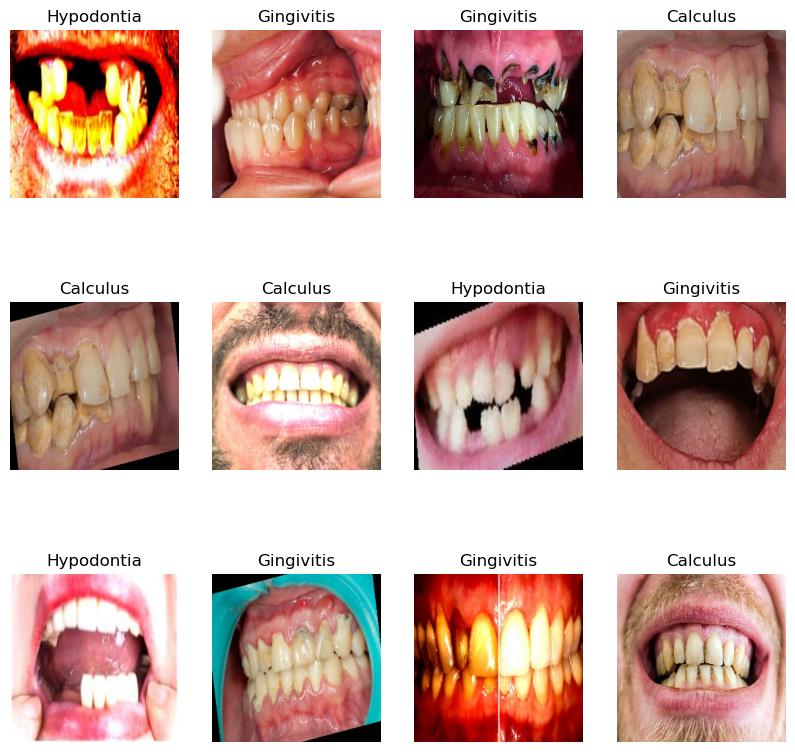

In [8]:
plt.figure(figsize =(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
    
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [9]:
train_size = 0.8
len(dataset)*train_size

139.20000000000002

In [10]:
train_ds = dataset.take(139)
len(train_ds)

139

In [11]:
test_ds = dataset.skip(139)
len(test_ds)

35

In [12]:
val_size = 0.1
len(dataset)*val_size

17.400000000000002

In [13]:
val_ds = test_ds.take(17)
len(val_ds)

17

In [14]:
test_ds = test_ds.skip(17)
len(test_ds)

18

In [15]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 69)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds
    

In [16]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [17]:
len(train_ds)

139

In [18]:
len(val_ds)

17

In [19]:
len(test_ds)

18

In [20]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [21]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [22]:
data_augmentation = tf.keras.Sequential([
     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
     layers.experimental.preprocessing.RandomRotation(0.2),
])

In [23]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 6
model = models.Sequential([resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape ),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'), 
    layers.MaxPooling2D((2,2)), 
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)), 
     layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation = 'softmax'),                       
])
                        
model.build(input_shape = input_shape)

In [24]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [25]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [26]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds

 )

Epoch 1/50
139/139 [==============================] - 587s 4s/step - loss: 1.3580 - accuracy: 0.4418 - val_loss: 1.2888 - val_accuracy: 0.5037
Epoch 2/50
139/139 [==============================] - 428s 3s/step - loss: 1.1257 - accuracy: 0.5546 - val_loss: 1.1351 - val_accuracy: 0.5386
Epoch 3/50
139/139 [==============================] - 427s 3s/step - loss: 1.0553 - accuracy: 0.5827 - val_loss: 0.9877 - val_accuracy: 0.6342
Epoch 4/50
139/139 [==============================] - 430s 3s/step - loss: 0.9757 - accuracy: 0.6016 - val_loss: 0.9718 - val_accuracy: 0.5901
Epoch 5/50
139/139 [==============================] - 422s 3s/step - loss: 0.9328 - accuracy: 0.6156 - val_loss: 0.8474 - val_accuracy: 0.6489
Epoch 6/50
139/139 [==============================] - 427s 3s/step - loss: 0.8734 - accuracy: 0.6460 - val_loss: 0.8166 - val_accuracy: 0.6471
Epoch 7/50
139/139 [==============================] - 461s 3s/step - loss: 0.8582 - accuracy: 0.6433 - val_loss: 0.7933 - val_accuracy: 0.6654

In [27]:
scores = model.evaluate(test_ds)

17/17 [==============================] - 12s 673ms/step - loss: 0.4227 - accuracy: 0.8235


In [28]:
scores

[0.42265182733535767, 0.8235294222831726]

In [29]:
history

In [30]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 139}

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

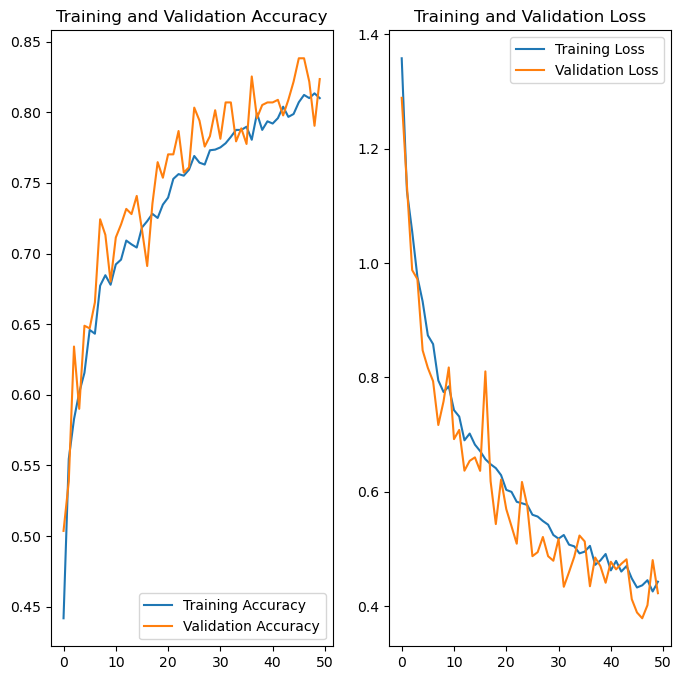

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc,label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss,label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
np.argmax([9.9999994e-01, 1.2288780e-09, 2.2414842e-19])

First image to predict
Actual label Hypodontia
1/1 [==============================] - 2s 2s/step
predicted Label Hypodontia


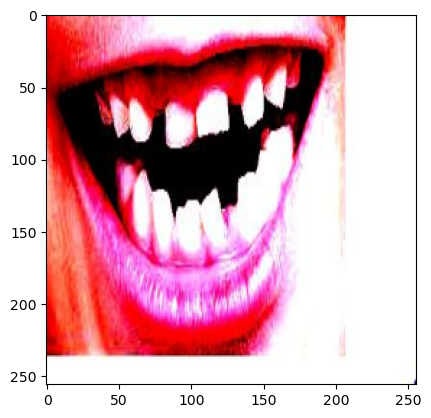

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("First image to predict")
    plt.imshow(first_image)
    print("Actual label",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted Label",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 52ms/step


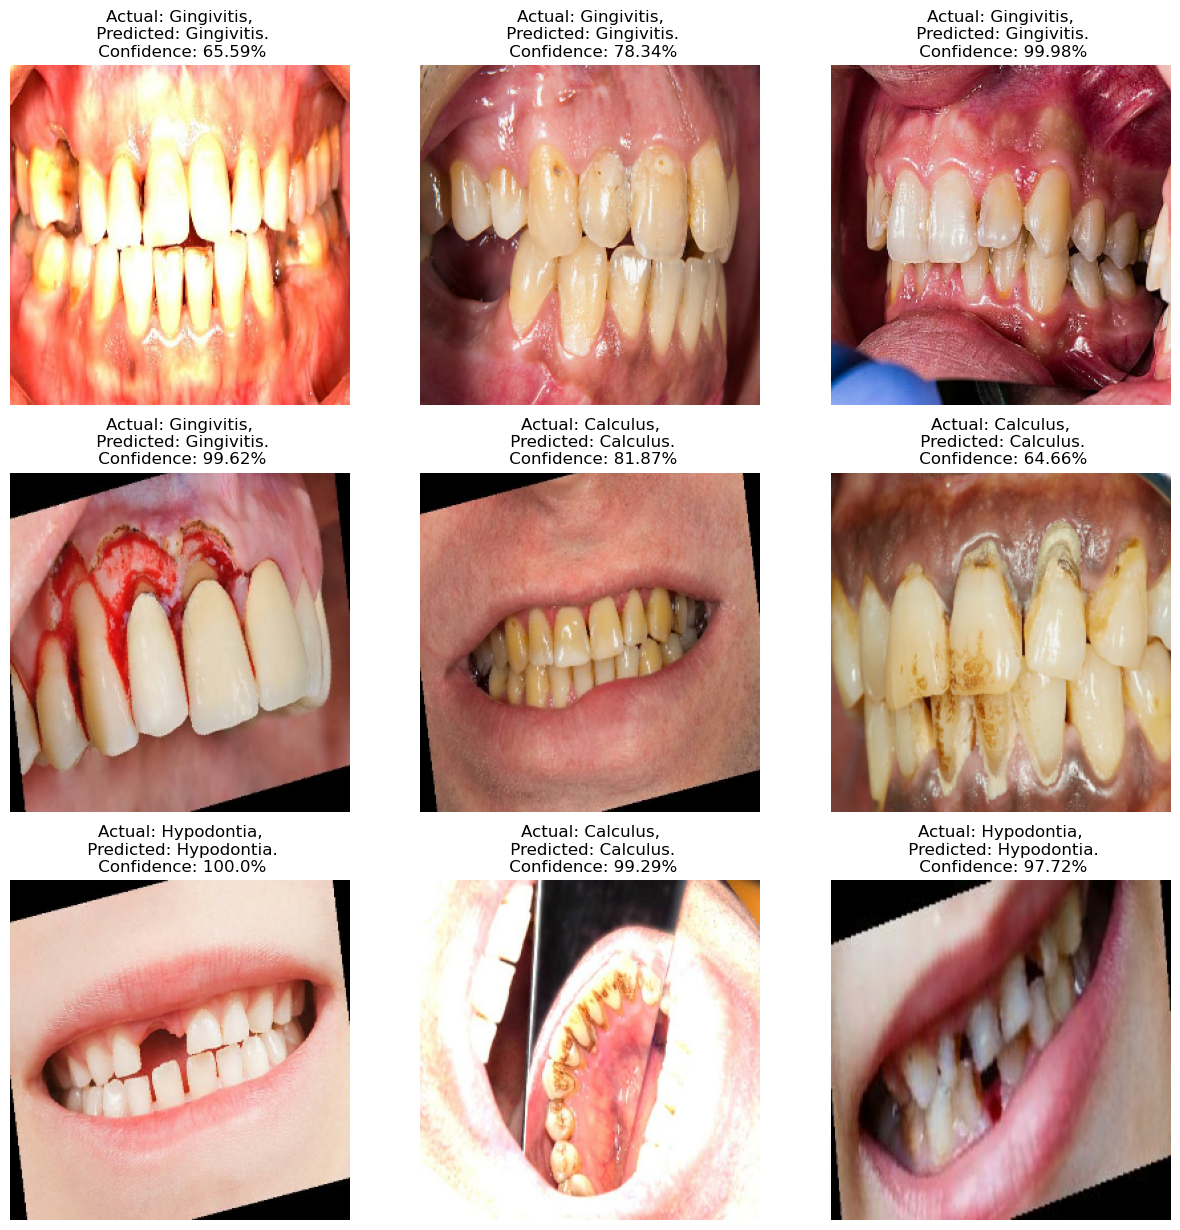

In [36]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [38]:
model_version=2
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/2/assets


INFO:tensorflow:Assets written to: ../models/2/assets
